In [22]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [23]:
file_path = "dataset/ibm.csv"
data = pd.read_csv(file_path)

print(data.head())

                        Date      Open      High       Low     Close  Volume  \
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940   
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955   
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575   
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405   
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


#### Data Cleaning and Preprocessing

In [24]:
data_filtered = data[["Date", "Open", "High", "Low", "Close", "Volume"]].sort_values(by="Date")
data_cleaned = data_filtered.dropna()
print(data_filtered.head())

                        Date      Open      High       Low     Close  Volume
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685


In [25]:
data_cleaned.to_csv("dataset/cleaned_ibm_data.csv", index=False)

In [26]:
file_path = "dataset/cleaned_ibm_data.csv"
data = pd.read_csv(file_path)
data.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02 00:00:00-05:00,1.530517,1.530517,1.513320,1.513320,407940
1,1962-01-03 00:00:00-05:00,1.513320,1.526548,1.513320,1.526548,305955
2,1962-01-04 00:00:00-05:00,1.526548,1.526548,1.510674,1.511336,274575
3,1962-01-05 00:00:00-05:00,1.509353,1.509353,1.478927,1.481573,384405
4,1962-01-08 00:00:00-05:00,1.480251,1.480251,1.441889,1.453794,572685


In [27]:
#  Only 'Close' price is used for prediction
data_close = data["Close"].values
# N * 1 column vector
data_close = data_close.reshape(-1, 1)
data_close

array([[  1.51332045],
       [  1.52654803],
       [  1.51133561],
       ...,
       [219.3500061 ],
       [219.72999573],
       [221.49000549]])

In [30]:
# Data normalization using a MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)
data_scaled.shape

(15797, 1)

The output implies the presence of 15797 rows of data with one "closing price" feature

### Preparing data to feed into LSTM model

In [31]:
def create_sequences(data, time_step):
    X = np.array([data[i : i + time_step, 0] for i in range(len(data) - time_step - 1)])
    y = np.array([data[i + time_step, 0] for i in range(len(data) - time_step - 1)])
    return X, y

In [32]:
# Input reshaped to [samples, time steps, features]

time_step = 60
X, y = create_sequences(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape, y.shape

((15736, 60, 1), (15736,))

In [33]:
# Data split into training and test sets (80:20 ratio)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
X_train.shape, X_test.shape

((12588, 60, 1), (3148, 60, 1))

In [37]:
# Single Layer LSTM
def create_single_lstm_model(time_step, features=1):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(time_step, features)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model
time_steps = 60
model_single_lstm = create_single_lstm_model(time_steps)

In [38]:
# Train the model
history_single_lstm = model_single_lstm.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=30)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0013 - mean_absolute_error: 0.0160 - val_loss: 7.6109e-05 - val_mean_absolute_error: 0.0062
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.6598e-05 - mean_absolute_error: 0.0042 - val_loss: 2.7247e-04 - val_mean_absolute_error: 0.0138
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.3500e-05 - mean_absolute_error: 0.0043 - val_loss: 8.0374e-05 - val_mean_absolute_error: 0.0066
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.0577e-05 - mean_absolute_error: 0.0038 - val_loss: 9.8623e-05 - val_mean_absolute_error: 0.0072
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.0330e-05 - mean_absolute_error: 0.0035 - val_loss: 5.3425e-05 - val_mean_absolute_error: 0.0052
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.7250e-05 - mean_absolute_error: 0.0033 - val_loss: 1.3559e-04 - val_mean_absolute_error: 0.0093
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/st

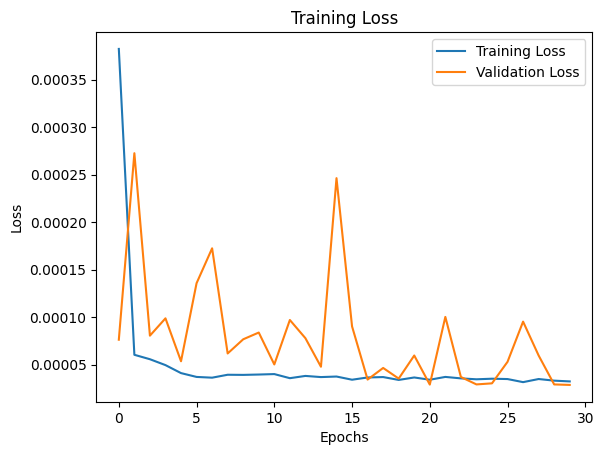

In [41]:
plt.plot(history_single_lstm.history["loss"], label="Training Loss")
plt.plot(history_single_lstm.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("LSTM_SINGLE_LOSS", bbox_inches="tight")

### Trying RNN and GRU models

In [42]:
def create_rnn_model(time_step, features=1):
    model = Sequential()
    model.add(
        SimpleRNN(units=50, return_sequences=True, input_shape=(time_step, features))
    )
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


time_steps = 60
model_rnn = create_rnn_model(time_steps)

In [43]:

history_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=30)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0118 - mean_absolute_error: 0.0553 - val_loss: 9.8897e-04 - val_mean_absolute_error: 0.0205
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 4.4179e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0015 - val_mean_absolute_error: 0.0299
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2.3711e-04 - mean_absolute_error: 0.0082 - val_loss: 5.2822e-04 - val_mean_absolute_error: 0.0151
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.6928e-04 - mean_absolute_error: 0.0067 - val_loss: 5.3480e-04 - val_mean_absolute_error: 0.0161
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.3406e-04 - mean_absolute_error: 0.0061 - val_loss: 2.5294e-04 - val_mean_absolute_error: 0.0108
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0020e-04 - mean_absolute_error: 0.0054 - val_loss: 6.4180e-04 - val_mean_absolute_error: 0.0195
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step -

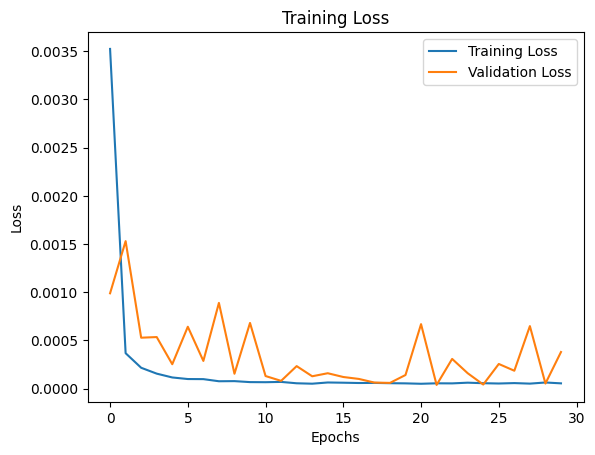

In [44]:
plt.plot(history_rnn.history["loss"], label="Training Loss")
plt.plot(history_rnn.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("RNN_LOSS.png", bbox_inches="tight")

## Intrepet the result


### Gated Recurrent Unit


In [46]:


def create_gru_model(time_step, features=1):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, features)))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model
time_steps = 60
model_gru = create_gru_model(time_steps)

In [47]:
history_gru = model_gru.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=30)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 7.6266e-04 - mean_absolute_error: 0.0127 - val_loss: 1.8420e-04 - val_mean_absolute_error: 0.0117
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 6.8175e-05 - mean_absolute_error: 0.0046 - val_loss: 3.7056e-05 - val_mean_absolute_error: 0.0043
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 5.8036e-05 - mean_absolute_error: 0.0044 - val_loss: 1.8832e-04 - val_mean_absolute_error: 0.0116
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 6.4271e-05 - mean_absolute_error: 0.0046 - val_loss: 2.8095e-04 - val_mean_absolute_error: 0.0149
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 5.3004e-05 - mean_absolute_error: 0.0043 - val_loss: 4.3637e-05 - val_mean_absolute_error: 0.0049
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 5.4324e-05 - mean_absolute_error: 0.0044 - val_loss: 3.3478e-05 - val_mean_absolute_error: 0.0042
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 

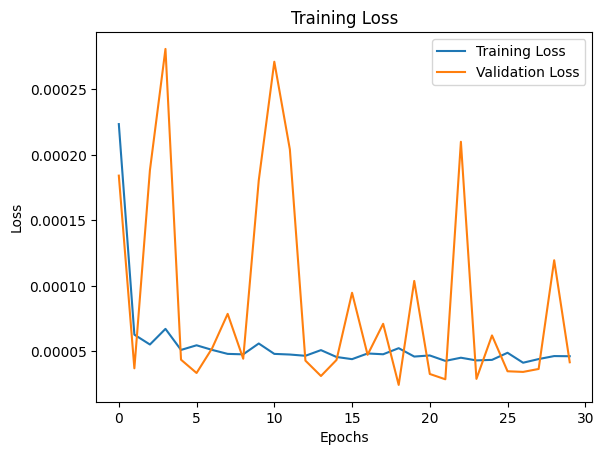

In [48]:
plt.plot(history_gru.history["loss"], label="Training Loss")
plt.plot(history_gru.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("GRU_LOSS.png", bbox_inches="tight")

### Use Multi_Layer LSTM model

In [49]:
# Multi layer LSTM model definition 

def create_multi__lstm_model(time_step, features=1):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model

time_steps = 60
model_multi_lstm = create_multi__lstm_model(time_steps)

In [50]:
history_multi_lstm = model_multi_lstm.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=30)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 5.8947e-04 - mean_absolute_error: 0.0109 - val_loss: 8.5431e-05 - val_mean_absolute_error: 0.0067
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 6.7891e-05 - mean_absolute_error: 0.0048 - val_loss: 7.6102e-05 - val_mean_absolute_error: 0.0063
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 5.8907e-05 - mean_absolute_error: 0.0041 - val_loss: 1.7153e-04 - val_mean_absolute_error: 0.0093
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 5.5381e-05 - mean_absolute_error: 0.0041 - val_loss: 1.5924e-04 - val_mean_absolute_error: 0.0108
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 5.5058e-05 - mean_absolute_error: 0.0041 - val_loss: 6.3084e-05 - val_mean_absolute_error: 0.0056
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 4.8609e-05 - mean_absolute_error: 0.0041 - val_loss: 8.8156e-05 - val_mean_absolute_error: 0.0069
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26

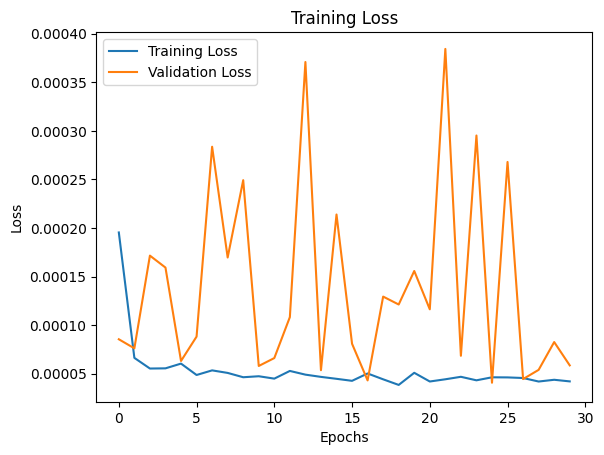

In [51]:
plt.plot(history_multi_lstm.history["loss"], label="Training Loss")
plt.plot(history_multi_lstm.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("LSTM_MULTI_LOSS.png", bbox_inches="tight")

## Testing the model on RNN

In [52]:
# Predict stock prices on the test set
predicted_stock_price = model_rnn.predict(X_test)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [74]:
# We get the actual stock price by inverse transforming the actual predicted stock price

predicted_stock_price_rnn = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

#### Calculating Error Metrices (MSE, RMSE and MAE)


In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predicted_stock_price_rnn)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_rnn)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 7.6477102117228615
Root Mean Squared Error (RMSE): 2.7654493688590396
Mean Absolute Error (MAE): 2.1473152010383267


## Testing the model on GRU

In [76]:
predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price_gru = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predicted_stock_price_gru)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_gru)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Squared Error (MSE): 8.789148995586174
Root Mean Squared Error (RMSE): 2.964649894268491
Mean Absolute Error (MAE): 2.339525048281368


### Testing the model on Single_Layer_LSTM


In [67]:
predicted_stock_price = model_single_lstm.predict(X_test)
predicted_stock_price_lstm_single = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predicted_stock_price_lstm_single)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_lstm_single)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 7.6477102117228615
Root Mean Squared Error (RMSE): 2.7654493688590396
Mean Absolute Error (MAE): 2.1473152010383267


### Testing the model on Multi_Layer_LSTM

In [77]:
predicted_stock_price = model_multi_lstm.predict(X_test)
predicted_stock_price_lstm_multi = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predicted_stock_price_lstm_multi)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_lstm_multi)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error (MSE): 34.5560991388484
Root Mean Squared Error (RMSE): 5.878443598338628
Mean Absolute Error (MAE): 4.545113925861131


### We target to imrpove the LSTM model at predictionso 
### We will try hyperparamters tuning
### Based on the professor's recommendation, we'll try to use tanh and observe any peformance changes/imrpovement

In [62]:
def create_multi_lstm_tanh_model(time_step, features=1):
    model = Sequential()
    model.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(time_step, features),
            activation="tanh",
            recurrent_activation="sigmoid",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            units=50,
            return_sequences=False,
            activation="tanh",
            recurrent_activation="sigmoid",
        )
    )
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation="linear"))
    # The inear activation at the output layer allows unrestricted output
    # model.add(Dense(units=1, activation='tanh'))  # if output values are expected within [-1, 1]
    # Since a stock prediction is a regression problem, a RMSE loss should be apt for this case
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


time_steps = 60
model_multi_lstm_tanh = create_multi_lstm_tanh_model(time_steps)

Validation while training might hinder the learning, so we try without validation

In [63]:
history_multi_lstm_model_tanh = model_multi_lstm_tanh.fit(
    X_train, y_train, batch_size=32, epochs=30
)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0017 - mean_absolute_error: 0.0196
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 1.8837e-04 - mean_absolute_error: 0.0078
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 1.6818e-04 - mean_absolute_error: 0.0082
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 1.4133e-04 - mean_absolute_error: 0.0075
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 1.4389e-04 - mean_absolute_error: 0.0078
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 1.3018e-04 - mean_absolute_error: 0.0073
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 1.2315e-04 - mean_absolute_error: 0.0073
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 1.2142e-04 - mean_absolute_error: 0.0074
Epoch 9/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 1.1242e-04 - mean_absolute_error: 0.0069
Epoch 10/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 1.1985e-04 - m

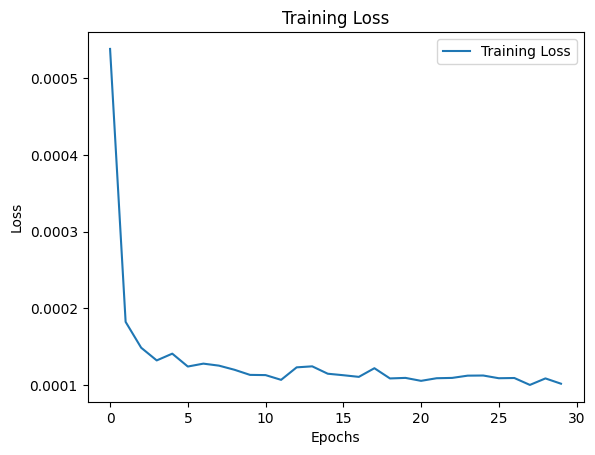

In [64]:
plt.plot(history_multi_lstm_model_tanh.history["loss"], label="Training Loss")
# plt.plot(history_multi_lstm_model_tanh.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig("MULTI_LSTM_TANH.png", bbox_inches="tight")

### Training with a validation loss

In [65]:
history_multi_lstm_model_tanh_with_validation = model_multi_lstm_tanh.fit(
    X_train, y_train, validation_split=0.2, batch_size=32, epochs=30
)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 4.6706e-05 - mean_absolute_error: 0.0049 - val_loss: 3.8960e-05 - val_mean_absolute_error: 0.0044
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 3.8033e-05 - mean_absolute_error: 0.0040 - val_loss: 5.7317e-05 - val_mean_absolute_error: 0.0053
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 3.8383e-05 - mean_absolute_error: 0.0038 - val_loss: 5.1679e-05 - val_mean_absolute_error: 0.0058
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 3.8698e-05 - mean_absolute_error: 0.0037 - val_loss: 5.1268e-05 - val_mean_absolute_error: 0.0049
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 3.6214e-05 - mean_absolute_error: 0.0034 - val_loss: 4.9159e-05 - val_mean_absolute_error: 0.0056
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 3.9682e-05 - mean_absolute_error: 0.0037 - val_loss: 1.0373e-04 - val_mean_absolute_error: 0.0090
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 27m

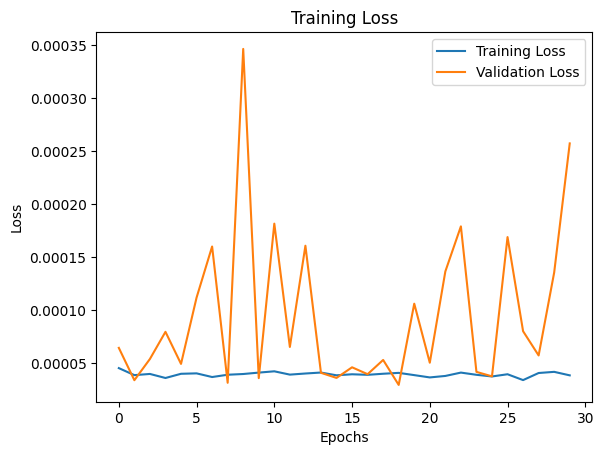

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(
    history_multi_lstm_model_tanh_with_validation.history["loss"], label="Training Loss"
)
plt.plot(
    history_multi_lstm_model_tanh_with_validation.history["val_loss"],
    label="Validation Loss",
)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("figurename.png", bbox_inches="tight")

### Testing the model on Multi_Layer_LSTM_TANH

In [79]:
predicted_stock_price = model_multi_lstm_tanh.predict(X_test)
predicted_stock_price_lstm_multi_tanh = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predicted_stock_price_lstm_multi_tanh)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predicted_stock_price_lstm_multi_tanh)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error (MSE): 128.22636343226654
Root Mean Squared Error (RMSE): 11.32370802485946
Mean Absolute Error (MAE): 8.803588823563262


In [80]:
dates = data["Date"].values
dates

array(['1962-01-02 00:00:00-05:00', '1962-01-03 00:00:00-05:00',
       '1962-01-04 00:00:00-05:00', ..., '2024-10-01 00:00:00-04:00',
       '2024-10-02 00:00:00-04:00', '2024-10-03 00:00:00-04:00'],
      dtype=object)

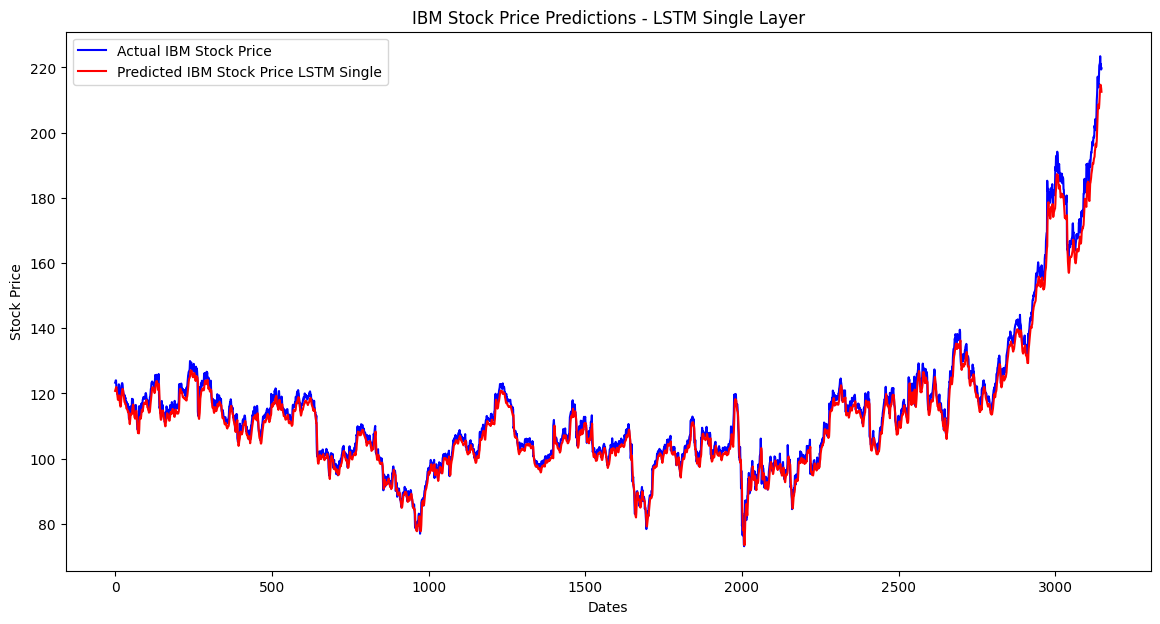

In [89]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_single, color="red", label="Predicted IBM Stock Price LSTM Single")
plt.title("IBM Stock Price Predictions - LSTM Single Layer")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

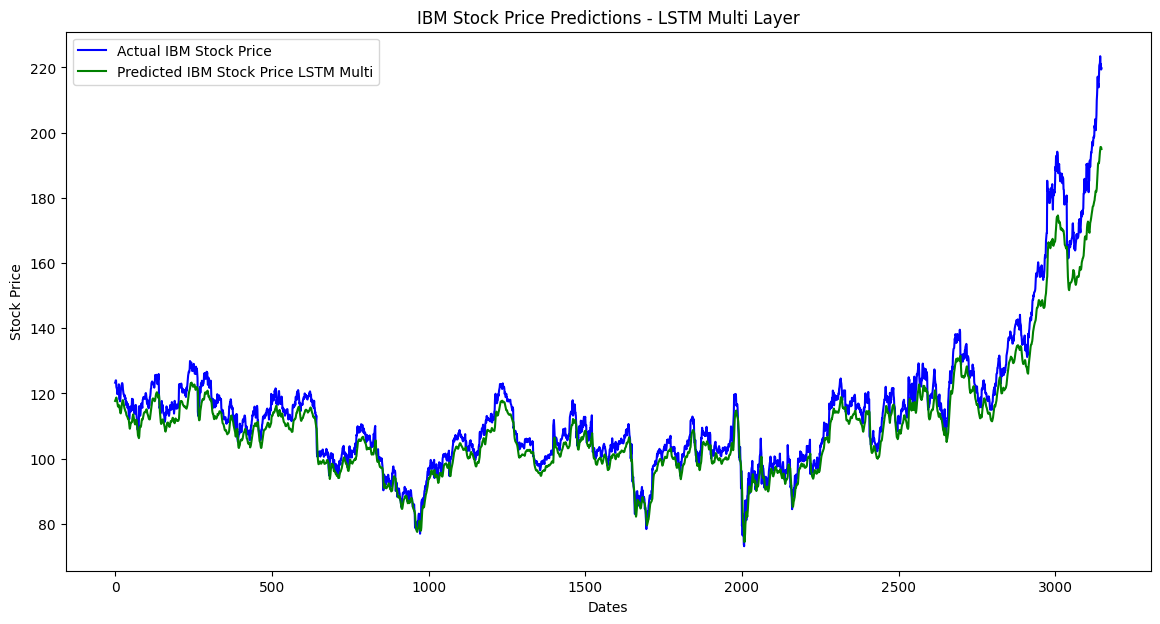

In [90]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_multi, color="green", label="Predicted IBM Stock Price LSTM Multi")
plt.title("IBM Stock Price Predictions - LSTM Multi Layer")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

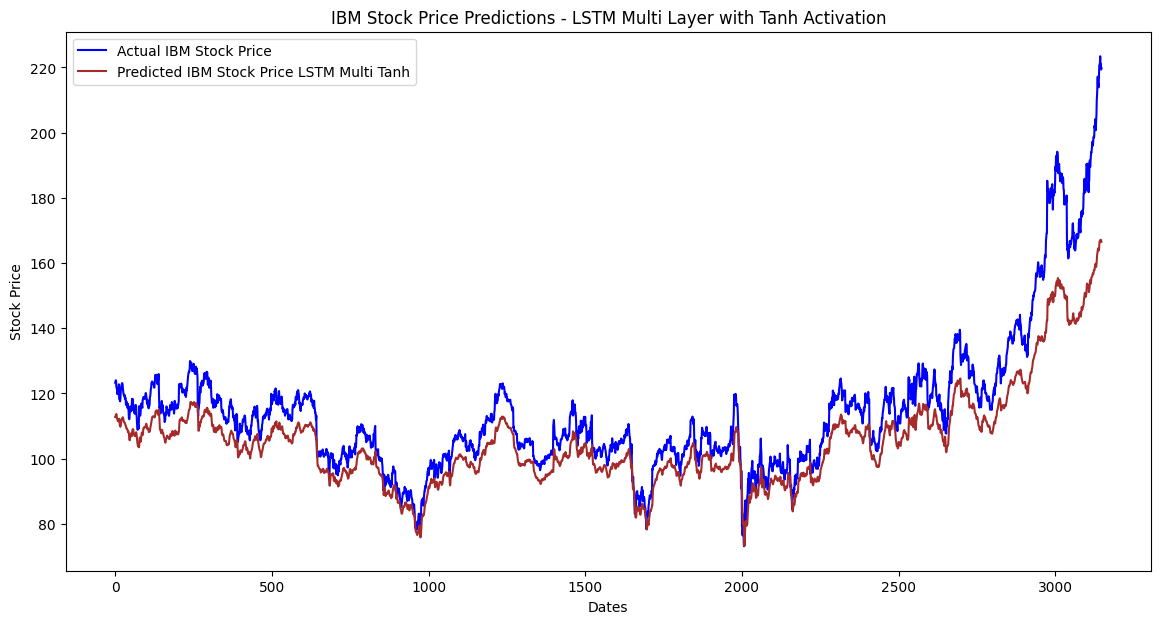

In [85]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_multi_tanh, color="brown", label="Predicted IBM Stock Price LSTM Multi Tanh")
plt.title("IBM Stock Price Predictions - LSTM Multi Layer with Tanh Activation")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

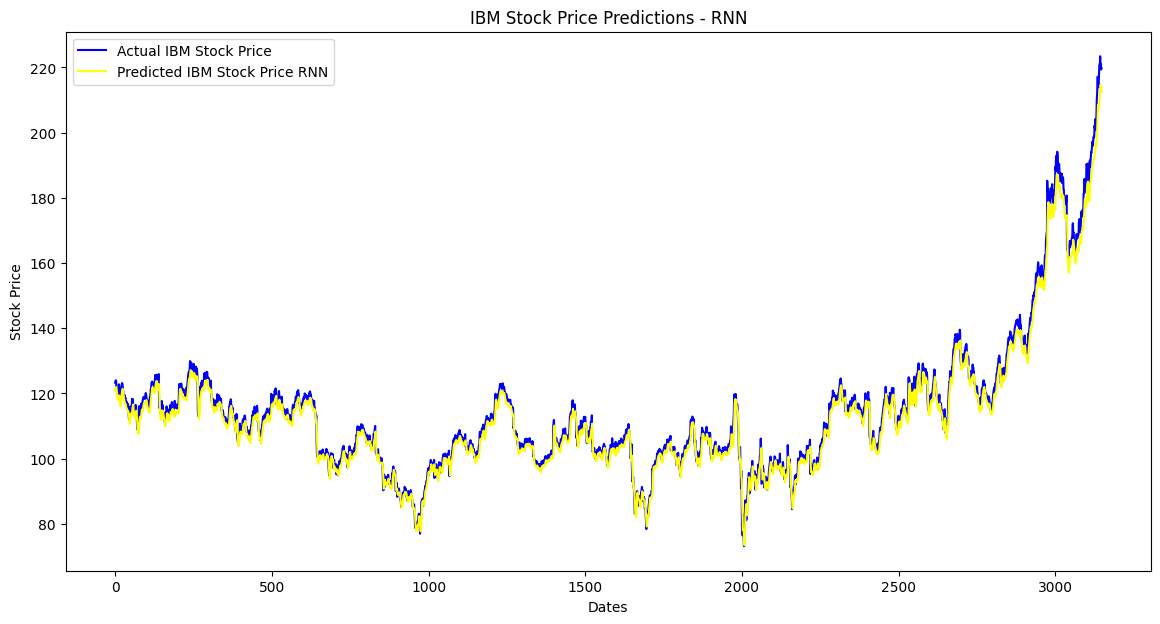

In [86]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_rnn, color="yellow", label="Predicted IBM Stock Price RNN")
plt.title("IBM Stock Price Predictions - RNN")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

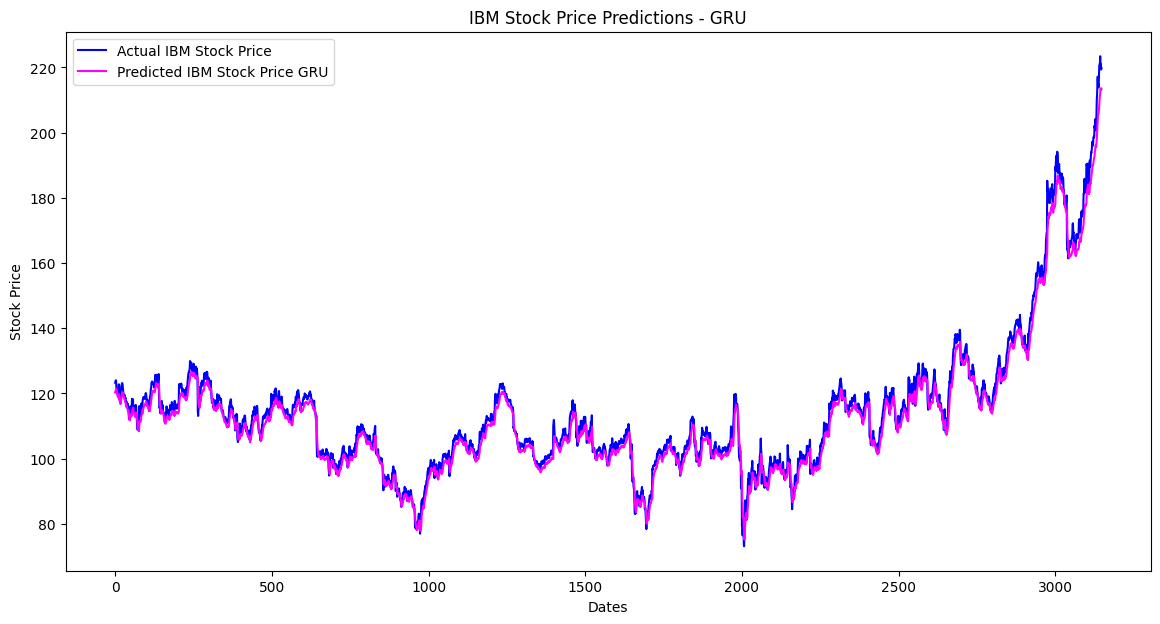

In [87]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_gru, color="magenta", label="Predicted IBM Stock Price GRU")
plt.title("IBM Stock Price Predictions - GRU")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

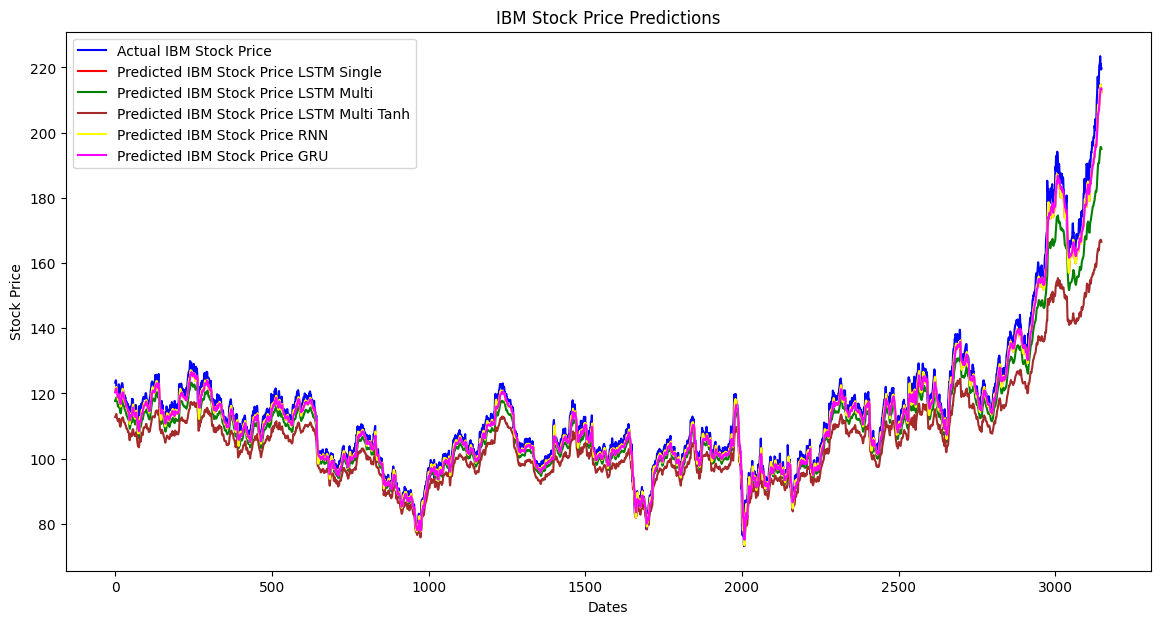

In [91]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color="blue", label="Actual IBM Stock Price")
plt.plot(predicted_stock_price_lstm_single, color="red", label="Predicted IBM Stock Price LSTM Single")
plt.plot(predicted_stock_price_lstm_multi, color="green", label="Predicted IBM Stock Price LSTM Multi")
plt.plot(predicted_stock_price_lstm_multi_tanh, color="brown", label="Predicted IBM Stock Price LSTM Multi Tanh")
plt.plot(predicted_stock_price_rnn, color="yellow", label="Predicted IBM Stock Price RNN")
plt.plot(predicted_stock_price_gru, color="magenta", label="Predicted IBM Stock Price GRU")
plt.title("IBM Stock Price Predictions")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.legend()
plt.show()